In [2]:
import numpy as np
import os
import json
import time
import matplotlib.pyplot as plt
from numba import jit
from skimage import io, exposure
from skimage.filters import threshold_otsu
from scipy import interpolate as interp
from scipy import ndimage, stats, special
from scipy.optimize import minimize, brute
from blender_tissue_cartography import rotation as tcrot
from blender_tissue_cartography import registration as tcreg
from blender_tissue_cartography import harmonic as tcharm
from spherical_analysis import * 

This Jupyter notebook contains code that visualizes the "great circle" generated by the rotations on the pullback. The great circle in our case is defined as a geodesic on a sphere $(\theta(t), \phi(t))$ which is confined to the plane determined by the rotation axis. When plotted on the pullback of the data, the great circle helps us visualize the rotations which are detected by the rotation finding script, serving as a debugging tool. Other applications are possible but not explored here. *Note, this assumes that the paths to the stacks are the ones specified in the `.json`.*

Start by reading in the `.json` of the dataset with the `rotation_to_next` parameter generated.

In [3]:
# parameters
json_dir = r"/mnt/data1/Code/GH_local/spherical_harmonic_rotation/dataset_5/"
json_name = r"dataset_5_rotation.json"

# read in stored json 
with open(os.path.join(json_dir, json_name), 'r') as f:
    dataset = json.load(f)

# sort by time if not already
dataset = dict(sorted(dataset.items(), key=lambda x: int(x[0][4:])))

# get the real time in minutes for each frame. (Assumes data is taken at 6 hpf)
times = np.array([int(x[4:]) for x in dataset.keys()])*5 + 360

# convert back necessary values back to nd_array
for d in dataset.values():
    d['center'] = np.array(d['center'])
    d['rotation_to_next'] = np.array(d['rotation_to_next'])

Set a save folder for the figures

In [3]:
# save dir
save_dir = r"DS05_greatcircle"
try:
    os.mkdir(save_dir)
except:
    print("Directory exists")

Directory exists


Here, we showcase the code for plotting the great circle on a single timepoint. Later on, we'll develop a general loop to go through all the timepoints.  
Without loss of generality, lets go with timepoint 90. We first visualize the pullback to see what we're working with.

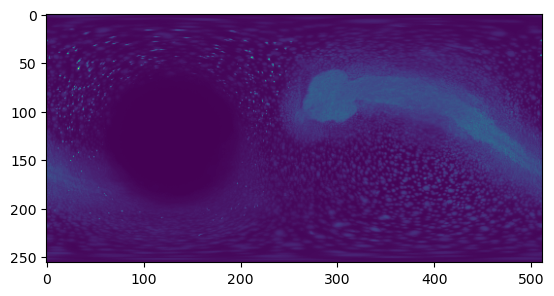

In [4]:
# select dataset for time 55
t_id = 'time84'
d = dataset[t_id]

# read in image
im = clip_pad_image(io.imread(d['path']), d['alpha'], d['padding'])

# create pullback
im_vol = create_interpolated_volume(im)
f = np.max(spherical_pullback(im_vol, d['center'], d['radius'], thickness=64, theta_res=256, phi_res=512), axis=0)

# view 
plt.imshow(f)

Read in the rotation matrix and find the the eigenvector with eigenvalue 1 (this is the rotation axis).

In [6]:
# load in rotation matrix for time 55
R = d['rotation_to_next']

# diagonalize to find the eigenvector which corresponds to no rotation
evals, evecs = np.linalg.eig(R)

print(evals)
print(evecs)
print(evecs[:, 2]) # eigenvector which corresponds to axis of rotation

[1.+5.60032631e-16j 1.-5.60032631e-16j 1.+0.00000000e+00j]
[[ 0.70710678+0.j          0.70710678-0.j          0.5089363 +0.j        ]
 [ 0.31354218-0.54168043j  0.31354218+0.54168043j  0.46991659+0.j        ]
 [-0.16484124+0.28478233j -0.16484124-0.28478233j  0.72122274+0.j        ]]
[0.5089363 +0.j 0.46991659+0.j 0.72122274+0.j]


To construct points on the great circle, we first sample from the plane that is defined by the eigenvector:
$$ ax + by + cz = 0$$
To sample, we can simply generate values of $x$ and $y$ and pick $z$ such that:
$$ z = -(a/c)x -(b/c)y $$
Finally, we can then turn the sampled points $(x_i, y_i, z_i) \to (\theta_i, \phi_i)$ with the necessary formulas. Below, we have code which will generate the points $(x_i, y_i, z_i)$. 

In [7]:
# extract plane coefficients
a, b, c = evecs[:, 2].astype(np.float64)

# select number of x y points to sample
num_samples = 15

# generate samples
pixel_scale = np.average(np.shape(im))
x_pts = np.linspace(-pixel_scale/6, pixel_scale/6, num_samples)
y_pts = np.linspace(-pixel_scale/6, pixel_scale/6, num_samples)
x, y = np.meshgrid(x_pts, y_pts, indexing='ij')

# evaluate the z component
z_samples = - (a*x.ravel() + b*y.ravel())/c

# turn into an array of points in 3D space
sample_points = np.column_stack((x.ravel(), y.ravel(), z_samples))


/tmp/ipykernel_315/3395611888.py:2: ComplexWarning: Casting complex values to real discards the imaginary part
  a, b, c = evecs[:, 2].astype(np.float64)


For each point $(x_i, y_i, z_i) \in \mathbb{R}^3$, we have the following formulas:
$$
\theta_i = \arctan_2(\sqrt{x^2 + y^2}/z)  \; \in (0, \pi) \\
\phi_i = \mathrm{arctan}_{0\to2\pi}(y/x) \; \in (0, 2\pi)
$$
Where $\arctan_2$ is the arctangent function able to output angles from $(0, \pi)$, and $\mathrm{arctan}_{0\to2\pi}$ is an arctan function that is able to output angles from 0 to 2pi assuming counterclockwise rotation from the positive x axis. (In the x-y plane.)

In [22]:
# convert to spherical points and adjust for the resolutions
def arctan0to2pi(y, x):
    """Defines an arctan function to be able to output angles from 0 to 2pi
    assuming counterclockwise rotation from the positive x axis.

    Parameters
    ----------
    y: (`float`)\n
    x: (`float`)
    """
    if y >= 0:
        return np.arctan2(y, x)
    if y < 0:
        return np.arctan2(-y, -x) + np.pi

theta_res = 256
phi_res = 512
theta_phi = [] 
for v in sample_points:
    x, y, z = v
    length_v = np.linalg.norm(v)
    theta = (np.arctan2(np.sqrt(x**2 + y**2), z)) * theta_res/np.pi
    phi = arctan0to2pi(y, x) * phi_res/(2*np.pi)
    theta_phi.append(np.array([theta, phi]))

We will now investigate our coordinate conversion, $(x, y, z) \to (\theta, \phi)$ by seeing if it agrees with the coordinate conversion in the `spherical_analysis` package. We test this by first first using the spherical coordinate function to convert a given input $(\theta, \phi) \to (x, y, z)$. Then I check if I get back the same values using the code I wrote above.

In [26]:
sph_coord = create_spherical_coords_given_center(0,0,0) 
x, y, z = sph_coord(d['radius'], np.pi/4, 2*np.pi/3)
print(np.arctan2(np.sqrt(x**2 + y**2), z), arctan0to2pi(y, x))
print(np.pi/4, 2*np.pi/3)

0.7853981633974482 2.0943951023931953
0.7853981633974483 2.0943951023931953


Looks good.

In [20]:
def confirm_points(arr, x_res, y_res):
    """Takes in a list of points (x,y). Returns true if all points (x,y) 
    are within  0 < x < x_res and 0 < y < y_res.

    Parameters
    ----------
    arr: (`list[(x, y)]`) List of 2D points. \n
    x_res: (`int`) \n
    y_res: (`int`)
    """
    for point in arr:
        if point[1] < 0 or point[1] > y_res:
            print("at least 1 y point out of bounds")
            return False
        if point[0] < 0 or point[0] > x_res:
            print("at least 1 x point out of bounds")
            return False
    return True

confirm_points(theta_phi, 256, 512)

at least 1 x point out of bounds


False

We can visualize the plane of rotation as through plotting the them on the image in different orientations. Here, I've used the colormap `viridis` and I have set the brighter color to mean points which have a smaller $x$, value.

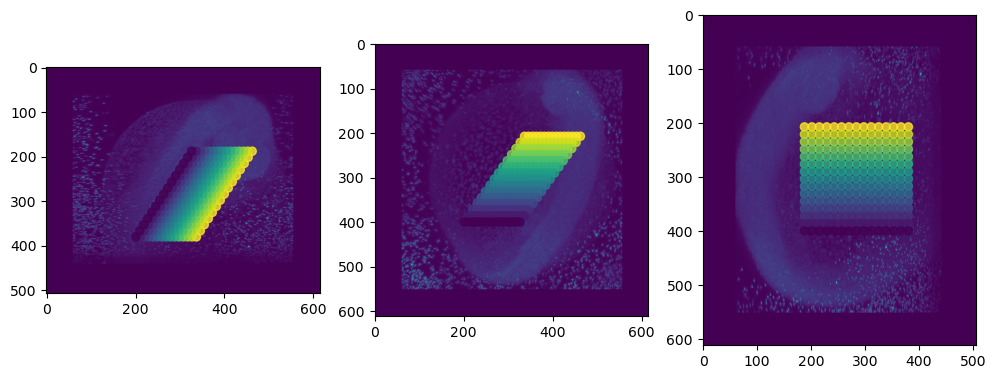

In [40]:
pts2 = sample_points + d['center']
# plot mip
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(12, 16))
ax1.imshow(np.max(im, axis=0))
ax1.scatter(pts2[:,2], pts2[:,1], c=-pts2[:,0], cmap='viridis', marker='o',s=35, alpha=0.8)
ax2.imshow(np.max(im, axis=1))
ax2.scatter(pts2[:,2], pts2[:,0], c=-pts2[:,0], cmap='viridis', marker='o',s=35, alpha=0.8)
ax3.imshow(np.max(im, axis=2))
ax3.scatter(pts2[:,1], pts2[:,0], c=-pts2[:,0], cmap='viridis', marker='o',s=35, alpha=0.8)

Finally, we can plot the points $(\theta, \phi)$ on the spherical projection of the fish.

(-0.5, 511.5, 268.825, -0.5)

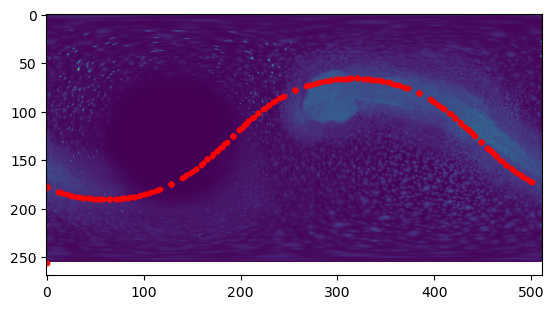

In [41]:
pts = np.array(theta_phi)
plt.imshow(f, origin='upper')
plt.scatter(pts[:, 1], pts[:, 0], marker='o', color='red', s=10)
#plt.scatter(128, 100, marker='x', color='green', s=30)
plt.axis('on')
# save
#plt.savefig(os.path.join(save_dir, f'{t_id}.png'), pad_inches=0)
#plt.close()

Now that we've done this for one timepoint, we can generalize and run through all timepoints.

In [ ]:
# convert to spherical points and adjust for the resolutions
def arctan0to2pi(y, x):
    """Defines an arctan function to be able to output angles from 0 to 2pi
    assuming counterclockwise rotation from the positive x axis.

    Parameters
    ----------
    y: (`float`)\n
    x: (`float`)
    """
    if y >= 0:
        return np.arctan2(y, x)
    if y < 0:
        return np.arctan2(-y, -x) + np.pi
    
def format_elapsed_time(time):
    """
    Returns the number of seconds elapsed and formats it into hours, minutes, and seconds.
    """
    hours, rem = divmod(time, 3600)
    minutes, seconds = divmod(rem, 60)
    return (hours, minutes, seconds)

theta_res=256
phi_res=512

script_start_time = time.time()

for t_id in dataset.keys():
    loop_start_time = time.time()
    print(f"Currently Processing {t_id}")

    d = dataset[t_id]
    
    # read in image
    im = clip_pad_image(io.imread(d['path']), d['alpha'], d['padding'])

    # create pullback
    im_vol = create_interpolated_volume(im)
    f = np.max(spherical_pullback(im_vol, d['center'], d['radius'], thickness=64, theta_res=theta_res, phi_res=phi_res), axis=0)

    # load in rotation matrix 
    R = d['rotation_to_next']

    # diagonalize to find the eigenvector which corresponds to no rotation
    evals, evecs = np.linalg.eig(R)

    # extract plane coefficients
    a, b, c = evecs[:, 2].astype(np.float64)

    # select number of x y points to sample
    num_samples = 8

    # generate samples
    x_pts = np.linspace(-10, 10, num_samples)
    y_pts = np.linspace(-10, 10, num_samples)
    x, y = np.meshgrid(x_pts, y_pts, indexing='ij')

    # evaluate the z component
    z_samples = - (a*x.ravel() + b*y.ravel())/c

    # turn into an array of points in 3D space
    sample_points = np.column_stack((x.ravel(), y.ravel(), z_samples))
    sample_pts_xy = np.vstack((x.ravel(), y.ravel()))

    # turn 3D points into points on sphere
    theta_phi = []
    for v in sample_points:
        x, y, z = v
        theta = (np.arctan2(np.sqrt(x**2 + y**2), z)) * theta_res/np.pi
        phi = arctan0to2pi(y, x) * phi_res/(2*np.pi)
        theta_phi.append(np.array([theta, phi]))

    pts = np.array(theta_phi)
    plt.imshow(f);
    plt.scatter(pts[:, 1], pts[:, 0], marker='o', color='red', s=10)
    plt.axis('off')
    # save
    plt.savefig(os.path.join(save_dir, f'{t_id}.png'), pad_inches=0)
    plt.close()
    loop_end_time = time.time()
    hrs, min, s = format_elapsed_time(loop_end_time - loop_start_time)
    print(f"Time per loop: {int(hrs)}:{int(min)}:{s:.6f}" )

script_end_time = time.time()
hrs, min, s = format_elapsed_time(script_end_time - script_start_time)
print(f"Elapsed time: {int(hrs)}:{int(min)}:{s:.6f}")
print("SCRIPT COMPLETE")


Currently Processing time0


/tmp/ipykernel_9453/1478790018.py:49: ComplexWarning: Casting complex values to real discards the imaginary part
  a, b, c = evecs[:, 2].astype(np.float64)


Time per loop: 0:0:13.845165
Currently Processing time1
Time per loop: 0:0:12.485556
Currently Processing time2
Time per loop: 0:0:12.511707
Currently Processing time3
Time per loop: 0:0:12.508194
Currently Processing time4
Time per loop: 0:0:12.387971
Currently Processing time5
Time per loop: 0:0:12.404951
Currently Processing time6
Time per loop: 0:0:12.525174
Currently Processing time7
Time per loop: 0:0:12.717096
Currently Processing time8
Time per loop: 0:0:12.788256
Currently Processing time9
Time per loop: 0:0:12.559637
Currently Processing time10
Time per loop: 0:0:12.700099
Currently Processing time11
Time per loop: 0:0:12.766339
Currently Processing time12
Time per loop: 0:0:12.726106
Currently Processing time13
Time per loop: 0:0:12.752417
Currently Processing time14
Time per loop: 0:0:12.810086
Currently Processing time15
Time per loop: 0:0:12.588870
Currently Processing time16
Time per loop: 0:0:12.809027
Currently Processing time17
Time per loop: 0:0:12.810332
Currently P

LinAlgError: 0-dimensional array given. Array must be at least two-dimensional